In [1]:
from notebook_setup.with_matplotlib import *
init_nb()
toggle_code_button()

I'll be using this paper for the temperature-dependent constants of gold:

> *Harsha Reddy, Urcan Guler, Alexander V. Kildishev, Alexandra Boltasseva, and Vladimir M. Shalaev, "Temperature-dependent optical properties of gold thin films," Opt. Mater. Express 6, 2776-2802 (2016)*

They use the following description (“DCP model”) to fit their VASE data:

$$\hat{\varepsilon}(\omega) = \varepsilon_\infty - \frac{\omega_p^2}{\omega^2 + i \Gamma_D\omega}
    + \sum_j C_j \Omega_j \left( \frac{e^{i \phi_j}}{\Omega_j-\omega-i\gamma_j} + \frac{e^{-i \phi_j}}{\Omega_j+\omega+i\gamma_j} \right)$$
    
We'll use their 3rd cycle data for the 200nm film

In [2]:
dcp_data = pd.read_csv('data/temp_dep_Au_200nm_1.csv', skiprows=(1,), index_col=0)
pd.read_csv('data/temp_dep_Au_200nm_1.csv', header=[0,1], index_col=0)

T   epsilon_infty omega_pu Gamma_D    C1  phi1 gamma_1     E1     C2  phi2  \
°C              1       eV      eV     1    pi      eV     eV      1    pi   
23           1.99    8.706  0.0479  2.27 -0.25   1.205  3.110  0.225 -0.25   
100          2.41    8.834  0.0515  2.22 -0.25   1.205  3.085  0.251 -0.25   
200          2.08    8.879  0.0578  2.36 -0.25   1.307  3.175  0.324 -0.25   
300          1.83    8.856  0.0711  2.39 -0.25   1.301  3.194  0.349 -0.25   
400          1.85    8.847  0.0819  2.38 -0.25   1.320  3.203  0.377 -0.25   
500          1.59    8.778  0.0893  2.48 -0.25   1.368  3.221  0.381 -0.25   

T   gamma_2     E2   MSE  
°C       eV     eV     1  
23    0.250  2.628  1.51  
100   0.281  2.622  1.34  
200   0.332  2.615  0.96  
300   0.361  2.601  1.08  
400   0.398  2.590  0.98  
500   0.423  2.577  0.90

In [3]:
def get_epsilon(T, omega_rad_s):
    omega_eV = omega_rad_s * scipy.constants.value('Planck constant over 2 pi in eV s')
    idx = dcp_data.index
    if T in idx:
        dcp2 = dcp_data
    else:
        dcp2 = dcp_data.reindex(list(dcp_data.index) + [T]).interpolate('index')
    E1 = dcp2['E1'][T]
    E2 = dcp2['E2'][T]
    g1 = dcp2['gamma_1'][T]
    g2 = dcp2['gamma_2'][T]
    return (dcp2['epsilon_infty'][T] - dcp2['omega_pu'][T]**2 / (omega_eV**2 + 1.0j*dcp2['Gamma_D'][T]*omega_eV)
            + dcp2['C1'][T]*E1 * (np.exp(+1.0j*dcp2['phi1'][T]*np.pi) / (E1 - omega_eV - 1.0j * g1)
                                + np.exp(-1.0j*dcp2['phi1'][T]*np.pi) / (E1 + omega_eV + 1.0j * g1))
            + dcp2['C2'][T]*E2 * (np.exp(+1.0j*dcp2['phi2'][T]*np.pi) / (E2 - omega_eV - 1.0j * g2)
                                + np.exp(-1.0j*dcp2['phi2'][T]*np.pi) / (E2 + omega_eV + 1.0j * g2)))

In [4]:
wavelength = np.arange(300, 2000) * 1e-9
omega = 2 * np.pi * scipy.constants.speed_of_light / wavelength
epsilon23 = get_epsilon(23, omega)
epsilon500 = get_epsilon(500, omega)

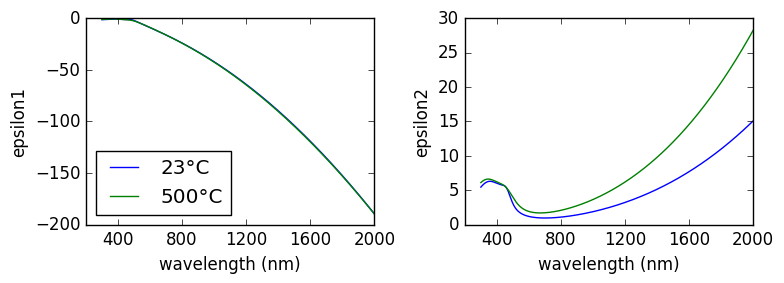

In [5]:
f = plt.figure(figsize=(8, 3))
ax1 = plt.subplot(121)
ax1.plot(wavelength*1e9, np.real(epsilon23), label='23°C')
ax1.plot(wavelength*1e9, np.real(epsilon500), label='500°C')
ax1.set_xticks([400, 800, 1200, 1600, 2000])
ax1.set_xlabel('wavelength (nm)')
ax1.set_ylabel('epsilon1')
ax1.legend(loc=0)
ax2 = plt.subplot(122)
ax2.plot(wavelength*1e9, np.imag(epsilon23), label='23°C')
ax2.plot(wavelength*1e9, np.imag(epsilon500), label='500°C')
ax2.set_xticks([400, 800, 1200, 1600, 2000])
ax2.set_xlabel('wavelength (nm)')
ax2.set_ylabel('epsilon2')

plt.tight_layout()

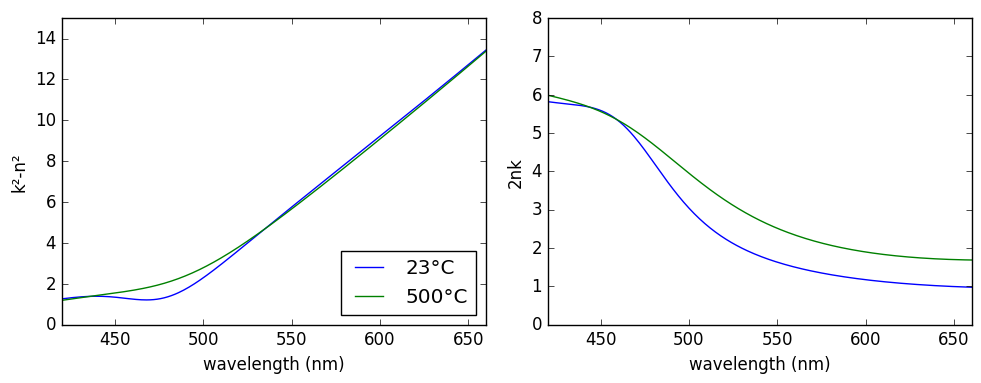

In [6]:
f = plt.figure(figsize=(10, 4))
ax1 = plt.subplot(121)
ax1.plot(wavelength*1e9, np.imag(np.sqrt(epsilon23))**2 - np.real(np.sqrt(epsilon23))**2, label='23°C')
ax1.plot(wavelength*1e9, np.imag(np.sqrt(epsilon500))**2 - np.real(np.sqrt(epsilon500))**2, label='500°C')
ax1.set_xticks([450, 500, 550, 600, 650])
ax1.set_xlim((420, 660))
ax1.set_xlabel('wavelength (nm)')
ax1.set_ylabel('k²-n²')
ax1.set_ylim(0, 15)
ax1.legend(loc=0)
ax2 = plt.subplot(122)
ax2.plot(wavelength*1e9, 2*np.real(np.sqrt(epsilon23))*np.imag(np.sqrt(epsilon23)), label='23°C')
ax2.plot(wavelength*1e9, 2*np.real(np.sqrt(epsilon500))*np.imag(np.sqrt(epsilon500)), label='23°C')
ax2.set_xticks([450, 500, 550, 600, 650])
ax2.set_xlim((420, 660))
ax2.set_xlabel('wavelength (nm)')
ax2.set_ylabel('2nk')
ax2.set_ylim(0, 8)

plt.tight_layout()